## Introduction

Many problems in quantitative fields such as finance and engineering are optimization problems. Optimization problems lie at the core of complex decision-making and definition of strategies. 

Optimization (or combinatorial optimization) means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized. This is typically called cost function or objective function. 

**Typical optimization problems**

Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects

Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects 

In this tutorial we briefly introduced QUBO models- a mathematical formulation of optimization problems.  The provide a step-by-step guide on how we can solve QUBO problems on qiskit. As an example, we consider max-cut problems which are of practical interest in many fields i.e network design, image segmentation, and VLSI circuit layout. We show how they can be mapped on quantum computers manually and how Qiskit optimization module supports this.

## Solving QUBO problems using quantum computing methods

Combinatorial optimization problems can be formulated as quadratic unconstrained binary optimization  (QUBO)  problems, expressed by the  following objective function 

$$C(x) = \sum_{i}^n Q_{i}x_i + \sum_{i,j}^n Q_{ij}x_ix_j +  \text{constant}.$$



where  $x_i\in\{0,1\}$ are  binary decision variables. The coefficients $Q_{i}$ and $Q_{ij}$ are the linear weights and quadratic couplers that define the problem. The QUBO problem is solved by finding the vector $x^*$ that is optimal with respect to the function $C(x)$ through the solution space of vectors. This is represented as

$$x^* = \arg\min_{x\in \mathbb{B}} f(x)$$


Examples of problems that can be formulated as QUBOS:

- Satifiability (SAT) problems
- Maximum Clique Problems
- <span style='color:red'>Maximum Cut (Max-cut) Problems</span> 
- Set Partitioning Problems / Number partitioning
- Set Packing Problems
- Graph Coloring Problems
- Warehouse Location Problems
- Maximum Independent Set Problems
- Number Partitioning Problems
- Linear Ordering Problems
- Clique Partitioning Problems
- Capital Budgeting Problems
- Multiple Knapsack Problems
- Task Allocation Problems (distributed computer systems)
- Maximum Diversity Problems
- P-Median Problems
- Asymmetric Assignment Problems
- Symmetric Assignment Problems
- Side Constrained Assignment Problems
- Quadratic Knapsack Problems


### Max-Cut problem

Consider an $n$-node undirected graph *G = (V, E)* where *|V| = n* with edge weights $w_{ij}>0$, $w_{ij}=w_{ji}$, for $(i, j)\in E$. A cut is defined as a partition of the original set V into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, *crossing* the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$, one tries to maximize the global profit function (here and in the following summations run over indices 0,1,...n-1)

$$\tilde{C}(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j).$$

For example: Consider the following graph 

![](maxcut.png)

The cost function of this graph is given by

$$\tilde{C}(\textbf{x}) =\sum_{i=0}^2\sum_{j=0}^2 w_{ij} x_i (1-x_j).$$

$$\tilde{C}(\textbf{x}) =  3x_0 +2x_1+2 x_2 +2x_3 - 2x_0x_1 -  2x_0x_2 -  2x_0x_3 - 2x_1x_2 - 2x_2x_3$$

> $x_i$ is a graph-colour of vertex $i$

In [6]:
#Check environment Environment
from qiskit.version import get_version_info as get_qiskit_version_info
from qiskit_ibm_runtime.version import get_version_info as get_runtime_version_info
from qiskit_algorithms.version import get_version_info as get_algorithms_version_info
from qiskit_optimization.version import get_version_info as get_optimization_version_info



print(f"Qiskit version: {get_qiskit_version_info()}")
print(f"Qiskit Runtime version: {get_runtime_version_info()}")
print(f"Qiskit algorithms version: {get_algorithms_version_info()}")
print(f"Qiskit optimization version: {get_optimization_version_info()}")


Qiskit version: 1.0.2
Qiskit Runtime version: 0.23.0
Qiskit algorithms version: 0.3.0
Qiskit optimization version: 0.6.1


In [7]:
# useful packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

## Defining the Maxcut Problem.

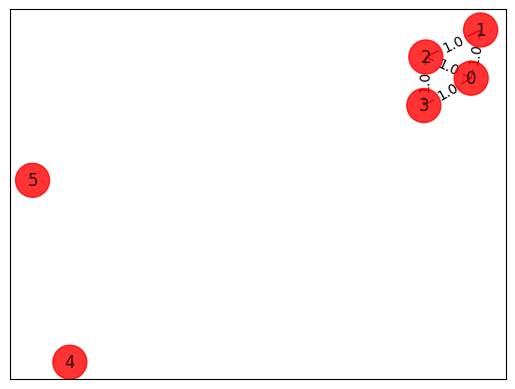

In [24]:
# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
#n = 5  # Number of nodes in graph

G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
#elist = [(0, 1, 1.0), (0, 2, 1.0), (1, 3, 1.0),(2,3,1.0),(2,4,1.0), (3, 4, 1.0)]

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [23]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


### Brute force approach

Try all possible $2^n$ combinations. For $n = 4$, as in this example, one deals with only 16 combinations, but for n = 1000, one has 1.071509e+30 combinations, which is impractical to deal with by using a brute force approach. 

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


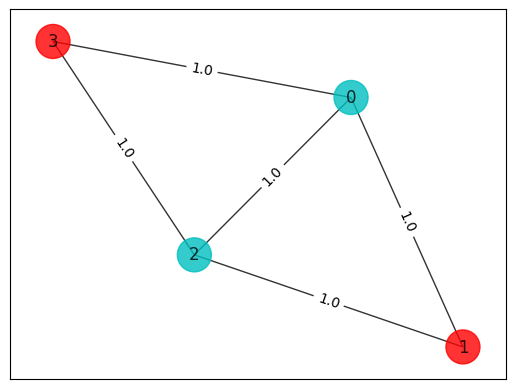

In [10]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

In order to find a solution to this problem on a quantum computer, one needs first to map it to an Ising Hamiltonian. This can be done with the assignment $x_i\rightarrow (1-Z_i)/2$, where $Z_i$ is the Pauli Z operator that has eigenvalues $\pm 1$. Doing this we find that 

$$C(\textbf{Z}) = \sum_{i,j} \frac{w_{ij}}{4} (1-Z_i)(1+Z_j) + \sum_i \frac{w_i}{2} (1-Z_i) = -\frac{1}{2}\left( \sum_{i<j} w_{ij} Z_i Z_j +\sum_i w_i Z_i\right)+\mathrm{const},$$

where $\mathrm{const} = \sum_{i<j}w_{ij}/2+\sum_i w_i/2$. In other terms, the weighted Max-Cut problem is equivalent to minimizing the Ising Hamiltonian 

$$ H = \sum_i w_i Z_i + \sum_{i<j} w_{ij} Z_iZ_j.$$

Qiskit optimization module can generate the Ising Hamiltonian for the first profit function $\tilde{C}$.
To this extent, function $\tilde{C}$ can be modeled as a `QuadraticProgram`, which provides the `to_ising()` method.



### Approximate Universal Quantum Computing for Optimization Problems

There has been a considerable amount of interest in recent times about the use of quantum computers to find a solution to combinatorial optimization problems. It is important to say that, given the classical nature of combinatorial problems, exponential speedup in using quantum computers compared to the best classical algorithms is not guaranteed. However, due to the nature and importance of the target problems, it is worth investigating heuristic approaches on a quantum computer that could indeed speed up some problem instances. Here we demonstrate an approach that is based on the *Quantum Approximate Optimization Algorithm* (QAOA) by Farhi, Goldstone, and Gutmann (2014). We frame the algorithm in the context of *approximate quantum computing*, given its heuristic nature. 

The algorithm works as follows:

1. Choose the $w_i$ and $w_{ij}$ in the target Ising problem. In principle, even higher powers of Z are allowed.

1. Choose the depth of the quantum circuit $m$. Note that the depth can be modified adaptively.

1. Choose a set of controls $\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$, built using a quantum circuit made of C-Phase gates and single-qubit Y rotations, parameterized by the components of $\boldsymbol\theta$. 

1. Evaluate 
$$C(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H|~\psi(\boldsymbol\theta)\rangle = \sum_i w_i \langle\psi(\boldsymbol\theta)~|Z_i|~\psi(\boldsymbol\theta)\rangle+ \sum_{i<j} w_{ij} \langle\psi(\boldsymbol\theta)~|Z_iZ_j|~\psi(\boldsymbol\theta)\rangle$$ 
by sampling the outcome of the circuit in the Z-basis and adding the expectation values of the individual Ising terms together. In general, different control points around $\boldsymbol\theta$ have to be estimated, depending on the classical optimizer chosen. 

1. Use a classical optimizer to choose a new set of controls.

1. Continue until $C(\boldsymbol\theta)$ reaches a minimum, close enough to the solution $\boldsymbol\theta^*$.

1. Use the last $\boldsymbol\theta$ to generate a final set of samples from the distribution $|\langle z_i~|\psi(\boldsymbol\theta)\rangle|^2\;\forall i$ to obtain the answer.
    
It is our belief the difficulty of finding good heuristic algorithms will come down to the choice of an appropriate trial wavefunction. For example, one could consider a trial function whose entanglement best aligns with the target problem, or simply make the amount of entanglement a variable. In this tutorial, we will consider a simple trial function of the form

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of C-Phase gates (fully entangling gates), and $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, where $n$ is the number of qubits and $m$ is the depth of the quantum circuit. The motivation for this choice is that for these classical problems this choice allows us to search over the space of quantum states that have only real coefficients, still exploiting the entanglement to potentially converge faster to the solution.

One advantage of using this sampling method compared to adiabatic approaches is that the target Ising Hamiltonian does not have to be implemented directly on hardware, allowing this algorithm not to be limited to the connectivity of the device. Furthermore, higher-order terms in the cost function, such as $Z_iZ_jZ_k$, can also be sampled efficiently, whereas in adiabatic or annealing approaches they are generally impractical to deal with. 


We will use Qiskit patterns to solve the Maxcut problem. 

<div class="alert alert-block alert-success"><b>Recap: </b> A qiskit pattern is an intuitive, repeatable set of steps for implementing a quantum computing workflow. Steps in a Qiskit Pattern:

    - Map classical inputs to a quantum problem
    - Optimize problem for quantum execution
    - Execute using Qiskit Runtime primitives
    - Post-process, return result in classical format
</div>

We will solve the Maxcut problem using the variationl quantum eigensolver.Executing a VQE algorithm requires the following 3 components:

   - Hamiltonian and ansatz (problem specification)
   - Qiskit Runtime estimator
   - Classical optimizer
    

### Step1: Map classical inputs to a quantum problem

Here the graph representation of the maxcut is tranformed to a QUBO foramat which is then mappled to the Ising problem. 
The QUBO model is related to the Ising model through the bijective relations $$h_i = \sum_{j} \frac{Q_{i,j}}{4}$$ and $$J_{ij} =  \frac{Q_{i,j}}{4}$$ which is obtained by substituting $x_i = \frac{1}{2}(\sigma_i+1)$ into the QUBO objective function.  For any given set of $h_i$ and $J_{ij}$ there exists at least one optimal solution $\sigma$ $= \{-1,1\}^n$  that minimizes the objective $E(h,J,\mathbf{\sigma})$  and the problem is to find the spin configuration (optimal solution) that minimizes the system energy.

In the Ising Hamiltonian,  the variables $x_i$ is mapped to the Pauli$_z$ operator $\sigma_i^z$ which acts as an  operator on qubit $i$. The objective function to optimize is then defined as an Ising Hamiltonian


   $$ H_\text{Ising} =  \sum_i^n h_i \sigma_i^z + \sum_{(i,j)}^n    J_{ij}  \sigma_i^z \sigma_j^z$$ 

Qiskit optimization provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.


In [11]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [12]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### solving Quadratic Program using exact classical eigensolver


In [13]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


Since the problem was cast to a minimization problem, the solution of $-4$ corresponds to the optimum.

#### Checking that the full Hamiltonian gives the right cost 

energy: -1.5
max-cut objective: -4.0
solution: [1. 0. 1. 0.]
solution objective: 4.0


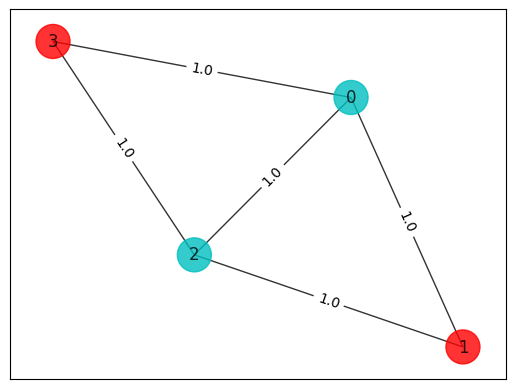

In [14]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

## Step2: Optimize problem for quantum execution


In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService

# service = QiskitRuntimeService(
#     channel='ibm_quantum',
#     instance='accelerated-disc/internal/default',
#     token='6e5c939d3d32996e48803433b071712104cd08cecacf15910097cdd0a5746d50f42f1459eea645ff8caa333558eab88ebc77de8269016e4cd61b7d7ec6651c72'
# )

# Or save your credentials on disk.
QiskitRuntimeService.save_account(channel='ibm_quantum', instance='accelerated-disc/internal/default', token='6e5c939d3d32996e48803433b071712104cd08cecacf15910097cdd0a5746d50f42f1459eea645ff8caa333558eab88ebc77de8269016e4cd61b7d7ec6651c72', overwrite=True)

Ansatz


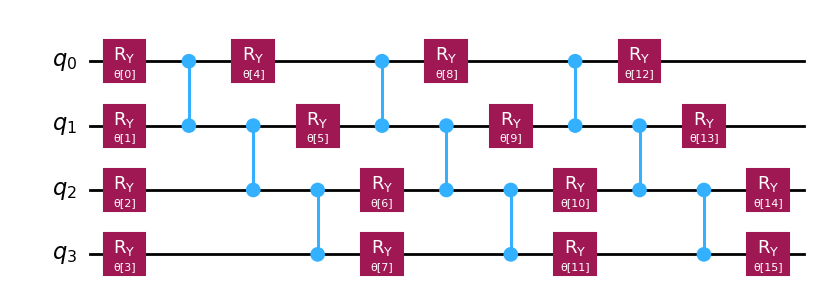

Transpiled ansatz


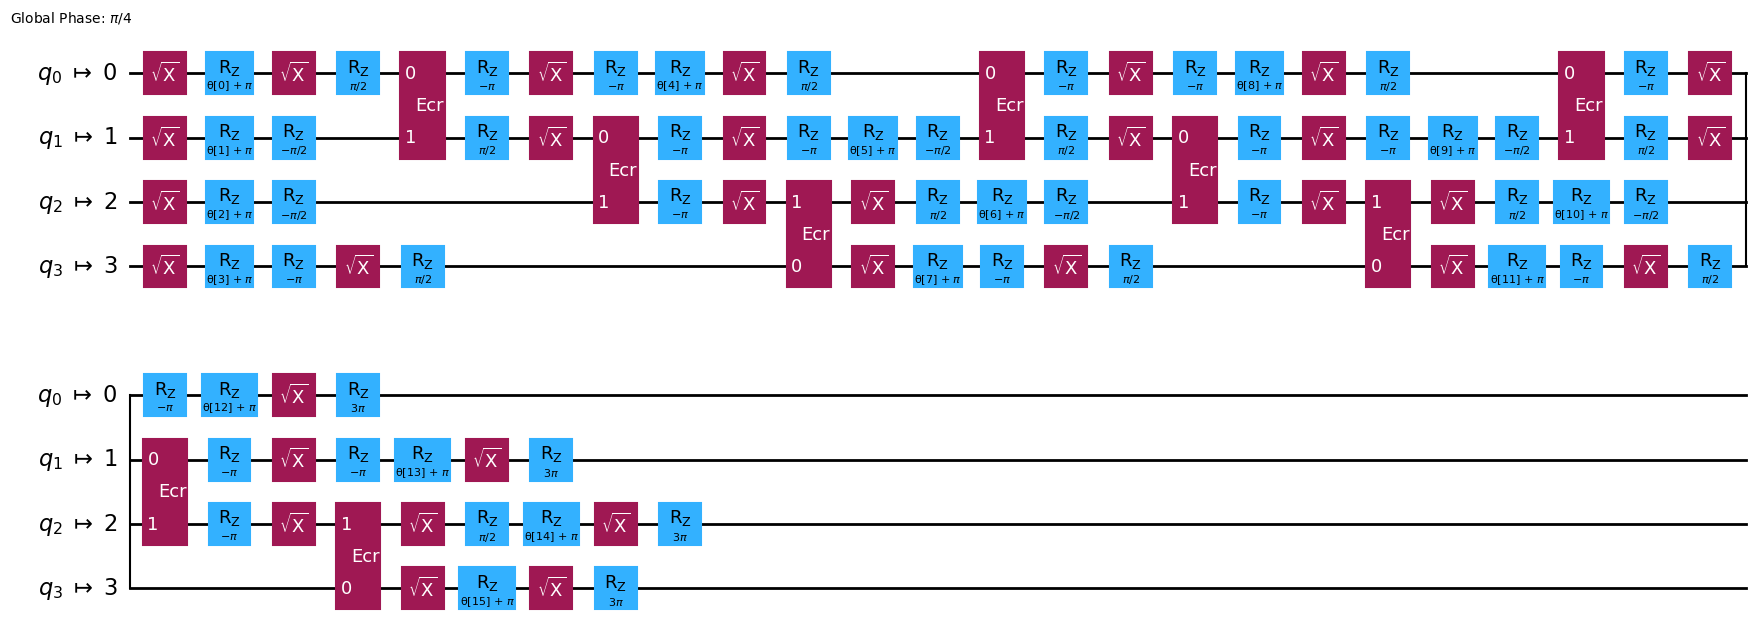

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService

# service = QiskitRuntimeService(
#     channel='ibm_quantum',
#     instance='ibm-q/open/main',
#     token='token'
# )


# #save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='token',overwrite=True)

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=3, entanglement="linear")

#Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(ry)

print('Ansatz')
display(ry.decompose().draw('mpl', idle_wires=False))

print('Transpiled ansatz')
isa_circuit.draw('mpl', idle_wires=False)

Similarly, we need to transform the Hamiltonian to make it backend compatible before running jobs with ```Runtime estimator V2```. We can perform the transformation using the ```Apply Layout```  the method of ```SparsePauliOP``` object.

In [17]:
hamiltonian_isa = qubitOp.apply_layout(layout=isa_circuit.layout)

### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [18]:
algorithm_globals.random_seed = 123
seed = 10598

energy: -1.4996861455587291
time: 0.8217339515686035
max-cut objective: -3.999686145558729
solution: [0 1 0 1]
solution objective: 4.0


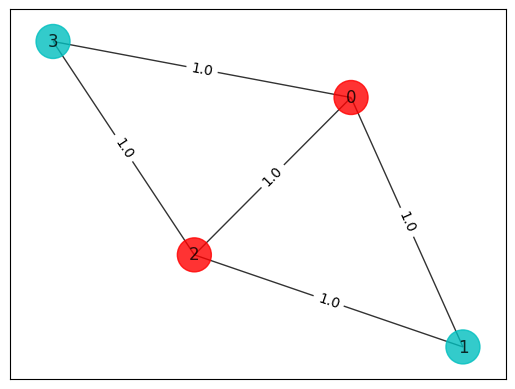

In [19]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


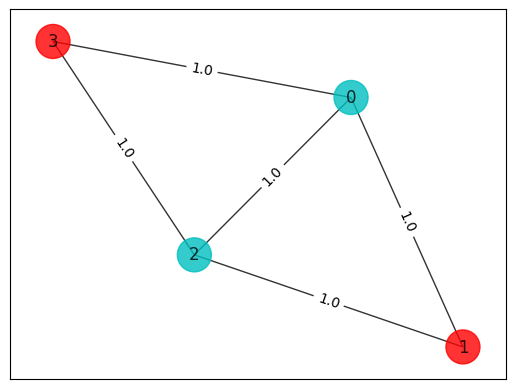

In [20]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

## Running on Hardware

In [21]:
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session


# AccessKey = "API Token"

# channel='ibm_quantum'
# instance= 'ibm-q/open/main'


# # Store your API token locally (only need to do once)
# QiskitRuntimeService.save_account(channel='ibm_quantum', token=AccessKey, overwrite=True)


# # Initialize a QiskitRuntimeService object
# service = QiskitRuntimeService()

# # Print the available backends
# print("Available backends:")
# for backend in service.backends():
#          print(backend.name)

In [22]:
# from qiskit_ibm_runtime import Sampler 

# service = QiskitRuntimeService()

# backend = service.least_busy(simulator=False, operational=True)

# # construct SamplingVQE
# optimizer = SPSA(maxiter=30)
# ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=3, entanglement="linear")

# #Convert to an ISA circuit and layout-mapped observables.
# pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
# isa_circuit = pm.run(ry)
# hamiltonian_isa = qubitOp.apply_layout(layout=isa_circuit.layout)



# vqe = SamplingVQE(sampler=Sampler(backend=backend), ansatz=isa_circuit, optimizer=optimizer)

# # run SamplingVQE
# result = vqe.compute_minimum_eigenvalue(hamiltonian_isa)

# # print results
# x = max_cut.sample_most_likely(result.eigenstate)
# print("energy:", result.eigenvalue.real)
# print("time:", result.optimizer_time)
# print("max-cut objective:", result.eigenvalue.real + offset)
# print("solution:", x)
# print("solution objective:", qp.objective.evaluate(x))

# # plot results
# colors = ["r" if x[i] == 0 else "c" for i in range(n)]
# draw_graph(G, colors, pos)


References:

- \ A. Lucas, Frontiers in Physics 2, 5 (2014)
- \ E. Farhi, J. Goldstone, S. Gutmann, e-print arXiv 1411.4028 (2014)
- \ D. Wecker, M. B. Hastings, M. Troyer, Phys. Rev. A 94, 022309 (2016)
- \ E. Farhi, J. Goldstone, S. Gutmann, H. Neven, e-print arXiv 1703.06199 (2017)
- https://qiskit-community.github.io/qiskit-optimization/tutorials/06_examples_max_cut_and_tsp.html
- https://qiskit-community.github.io/qiskit-optimization/tutorials/01_quadratic_program.html